* https://jovian.ai/aakashns/04-feedforward-nn

* In this chapter, we are using ReLU instead of softmax. ReLU is used because it imposes sparsity, is computationally fast, and empirically works well. Softplus is a smoothed approximation of ReLU (https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html), but ReLU works better. Interestingly enough, (Bertoin, 2021) claims that how to set the derivative of the ReLU function at x=0 (either 0 or 1) has an effect on the performance. https://scholar.google.com/scholar?hl=ko&as_sdt=0%2C44&q=Numerical+influence+of+ReLU%E2%80%99%280%29+on+backpropagation&btnG=
* When we apply parallel computation on SGD (DataLoader), there exist nodes that handle loading the next batch of data and a single node that processes updating parameters.

# 1. Introduction of hidden layer

In [ ]:
import torch
# import torchvision
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

## Display the images.

In [ ]:
dataset = MNIST(root='data/', download=False, transform=ToTensor()) # train=True is default

* ```plt.imshow()``` can plot a 28-28-1 tensor or 28-by-28 matrix. It cannot be 1-28-28.

In [ ]:
image, label = dataset[0]
print('image.shape:', image.shape)
# plt.imshow(image[0,:,:], cmap='gray')
plt.imshow(image.permute(1,2,0), cmap='gray')
print(torch.sum(image[0,:,:].reshape(28,28,1)!=image.permute(1,2,0)))

In [ ]:
# torch.manual_seed(0)
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

## Preparation of parallel & gpu coding

When loading the data, we can manage the number of cpus and adjust it so that we can make use of gpu.
* ```train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)```
* __num_workers__: number of cpus that we use (default=0: only the main processor).
* __pin_memory__: speed things up when using GPU, which helps in matrix multiplication.

We can pick out the numbers of cpus that are stored in this computer by the following code. However increasing the use of cpus does not always speed things up.
* ```import multiprocessing```
* ```nworkers = multiprocessing.cpu_count()``` : number of cpus in my computer

You may wonder why we need multiple cpus in SGD, where we update parameters sequentially one batch by one batch. In other words, only after we update the parameters, can we compute the gradients using the next batch, so it may seem that we would not need multiple cpus. However using multiple cpus still helps, because while the main processor handles the gradient (loss.backward(), opt.step(), etc.), the other cpu may load the next batch. This cooperation will speed things up.

In [ ]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

## Displaying multiple images together

We are going to plot the whole batch.
* ```plt.figure(figsize=(16,8))``` : adjust the size of the pane.
* ```plt.axis('off')``` : remove the y-index and x-index.
* ```make_grid(images, nrow=16)``` : images is a mini-batch of image tensors. nrow=16 means that each row has 16 images displayed, not the number of rows (unlike R). Python is row-wise for the most of the times, contrary to R, so the images are displayed so that it fills row by row. That is, they are aligned in the order of (1,1)-(1,2)-(1,3)$\cdots$. Do not forget to add ```.permute(1,2,0)``` at the end.

In [ ]:
for images, _ in train_loader: # a single batch
    print('image.shape:', images.shape)
#    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

## Hidden Layers

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1,784) # stretch it out so that we can use it as the input variable of a neural network.
    print('inputs.shape:', inputs.shape)
    break

* Given an array (or a tensor), [-1] gives us the last element. We can understand it in the following way. [0] indicates the 1st element, so [-1] goes backward by one step, which leads us to the last element.
* model=nn.Linear(p, K) $\rightarrow$ outpus = model(inputs), where inputs = $N\times p$ tensor, outputs = $N \times K$ tensor

In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32

In [ ]:
layer1 = nn.Linear(input_size, hidden_size)
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

* ```torch.allclose(tensor1, tensor2)``` tells us whether we can view the tensors as equal objects, given the specified tolerance. We can adjust the tolerance level, but is a little tricky to manage, having two tuning parameters rtol adn atol, so maybe using the default values may be good.

In [ ]:
manually_computed = inputs @ layer1.weight.t() + layer1.bias
print(torch.max(abs(manually_computed - layer1_outputs)).item())
torch.allclose(layer1_outputs, manually_computed)

## Relu

* F.relu: apply relu function to every entry of the tensor.

In [ ]:
F.relu(torch.tensor([
    [1.,-1,0],
    [-0.1, 0.2, 3]
]))

In [ ]:
relu_outputs = F.relu(layer1_outputs)
print("min(layer1_outputs):", torch.min(layer1_outputs).item())
print("min(relu_outputs):", torch.min(relu_outputs).item()) # But the maximum values are the same, of course.

## 2nd layer

In [ ]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [ ]:
layer2_outputs = layer2(relu_outputs)
layer2_outputs.shape

* Although we do not have a single "softmax" function in this page, ```F.cross_entropy``` already calculates softmax function, as noted in the file (3)-1. In addition, we do not have to transform the output values with softmax, because softmax is a monotone function.

In [ ]:
F.cross_entropy(layer2_outputs, labels)

In [ ]:
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias
torch.allclose(outputs, layer2_outputs, 1e-3)
torch.max(abs(outputs - layer2_outputs))

# 2. Form a model

In [ ]:
%reset
# I do not know why, but if we run this line, it returns an error in the gpu part. Just Ctrl+O and then start from the bottom line.

In [1]:
import torch
# import torchvision
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

torch.manual_seed(0)
dataset = MNIST(root='data/', download=False, transform=ToTensor()) # train=True is default
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

* torch.randn(4,4,4): form a 4-4-4 tensor with enteies sampled from normal(0,1). cannot control mean and sd.
* torch.normal(mean, std) controls mean and sd.
* Tensor.view(d1,d2) : same with .reshape(d1.d2)
* Tensor.view(d1) : size of d1-th dimension
* Tensor.size() : same with .shape()

In [2]:
x = torch.randn(4,4)
print(x.size())

y = x.view(16)
print(y.size())

z=x.view(-1,8)
print(z.size())

torch.Size([4, 4])
torch.Size([16])
torch.Size([2, 8])


* ```out = self(images)``` later works as ```out = model(images)```. ```self``` can serve as a function inside the definition of class.

In [3]:
class MnistModel(nn.Module):
    """Feedforward neural network with 1 hidden layer""" # This """""" part is not perceived as a code.
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # apply activation function
        out = F.relu(out)
        # get predictions using output layer
        out = self.linear2(out)
        return out # Do not forget to return it!
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # This part later works as model(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return { 'val_loss': loss, 'val_acc': acc }

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs ]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return { 'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item() }
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [5]:
# torch.manual_seed(0)
input_size=784
hidden_size=32
num_classes=10
model=MnistModel(in_size=input_size, hidden_size=hidden_size, out_size=num_classes)

In [6]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [7]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape :', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3219048976898193
outputs.shape : torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0750,  0.1490, -0.1672,  0.0790,  0.0533, -0.1593,  0.0053, -0.0226,
         -0.0271,  0.1055],
        [ 0.0084,  0.0769, -0.1341,  0.0802,  0.0049, -0.2751, -0.0895, -0.1251,
         -0.0241,  0.1025]])


# 3. GPU coding

* __torch.cuda.is.available()__ returns True if GPU is available.
* If we want to use GPU in calculations, we need to convert every single tensor objects to GPU-setting (or cuda) from the default cpu-setting. This is done by ```data.to(device)``` in torch.
* Every package has its own way of GPU-calculation, so we have to know how to convert it for each package.

In [8]:
torch.cuda.is_available()

True

In [9]:
def get_default_device(): # If gpu is available, then switch to gpu.
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [10]:
device = get_default_device()
device

device(type='cuda')

* ```isinstance(data, (list, tuple))``` : whether data is a list or tuple. Surprisingly list and a tuple is a class. In our case, we are concerned of the case when image is a list (tuple) of multiple tensors.
* ```non_blocking=True ``` : When transmitting the data from cpu-type into gpu-type, we apply asynchronous transmission.
* When sender synchronically transmits data to receiver, they send and receive it at the same time. To do this, we need an external clock in order for the sender to inform the receiver about the upcoming new byte. On the other hand, when the sender asyncrhonically transmits data to receiver, sending and receiving does not occur at the same time. Instead of using an external clock, they have separate clocks, using a stop bit and start bit, referred to as "parity bits." Since they put extra bits other than the data itself, asynchronous transmission takes more time to transmit the data, but it is more economical, because they do not require an additional clock signal for synchronizing the sending and receiving. Refer to the following websites.
* https://www.geeksforgeeks.org/difference-between-synchronous-and-asynchronous-transmission/
* https://spell.ml/blog/pytorch-training-tricks-YAnJqBEAACkARhgD
* https://www.geeksforgeeks.org/difference-between-synchronous-and-asynchronous-transmission/
* https://pytorch.org/docs/stable/generated/torch.Tensor.to.html
* https://www.youtube.com/watch?v=o7m1ytRt8es
* In conclusion, it works totally fine and gives us the same result with non_blocking=False or True.

* You may wonder why we need to define ```to_device(data, device)``` instead of merely returning ```data.to(device, non_blocking=True)```. If data is a single tensor object, we only need the latter. However in our case, each batch, which eventually becomes our input,is a tuple that contains two elements, both of which are tensor objects.
* Note that inside ```def to_device```, we are using ```to_device```. This may seem to be nonsense, but this holds, because once it gets inside ```if isinstance(data, (list, tuple))```, it reaches ```to_device(x,device)``` where ```x``` is the first element in ```data```. Now since ```x``` is a single tensor, we repeat ```to_device``` again, this time applying to a single tensor.

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data] # If it is a list (tuple), turn each element (tensor) into a cuda-controlled tensor.
    return data.to(device, non_blocking = True) # This applies when data is neither list nor tuple.
#    return data.to(device, non_blocking = False) 

* As soon as we reach return, everything stops. So in the case where if condition in add1() is satisfied, the second return does not count at all.
* The same holds for add2(). The second return x+1 does not count at all. 
* This is the difference between ```return``` and ```yield```. While everything else stops once ```return``` is reached, ```yield``` keeps generating objects. 

In [12]:
def add1(x):
    if x==1:
        return x+2
    return x+1
add1(1), add1(2)

(3, 3)

In [13]:
def add2(x):
    for i in range(10):
        return i
    return x+1
add2(1), add2(2), add2(3), add2(4), add2(5)

(0, 0, 0, 0, 0)

In [14]:
to_device( [torch.tensor([1.,2,3,4]), torch.tensor([1.,2,3,4])], device ) # converts each tensor in the list to cuda-based ones.

[tensor([1., 2., 3., 4.], device='cuda:0'),
 tensor([1., 2., 3., 4.], device='cuda:0')]

In [15]:
for images, labels in train_loader:
    print(images.device) # Before to_device, it is originally cpu-based.
    images = to_device(images, device)
    print(images.device) # After to_device, it is originally cuda-based.
    print(images.shape)
    break
isinstance(images, list)

cpu
cuda:0
torch.Size([128, 1, 28, 28])


False

* Without using ```to_device```, we can also use ```images.to(device, non_blocking=True)```, which is the original way of converting to cuda (gpu).

In [16]:
for images, labels in train_loader:
    print(images.device) # Before to_device, it is originally cpu-based.
    images = images.to(device, non_blocking=True)
    print(images.device) # After to_device, it is now cuda-based.
    break

cpu
cuda:0


In [17]:
a = [torch.tensor([1.,2,3,4]), torch.tensor([1.,2,3,4])]
a = torch.tensor([1,2,3,4.])
print(a)
b = [to_device(x, device) for x in a]
a.to(device, non_blocking = True) 
# b.to(device, non_blocking = True) 


tensor([1., 2., 3., 4.])


tensor([1., 2., 3., 4.], device='cuda:0')

* The reason we need ```to_device``` is because each batch is not a tensor, but a tuple with two different tensors.
* Note that the instance of ```DeviceDataLoader()``` is an iterable, not an iterator, since it does not contain ```__next__```. Therefore, although it contains ```yield```, it is not a generator. In addition, it is not made from a function, which is another evidence that shows that it is not a generator.
* Just because we input an iterable as the input in  a class (e.g. ```dl``` in the following example), it does not mean that the instance of that class automatically becomes an iterable object. Memorize the line under ```def __init__(self):``` in the following example.

Why do we define ```DeviceDataLoader()``` and not start everything from gpu?
* If we start everything from gpu, then we would consume a lot of gpu memory. So we are only using gpu memory just as much as we need.
* This partly explains why we are not using the whole validation data as a single batch. Although we are eventually going to use every single image in the validation data, we can be using less gpu memory if we split the validation data into multiple batches, because we are only going to transfer the samples in a single batch to the gpu memory.

In [18]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self): ### MEMORIZE THIS PART AS A TEMPLATE.
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # cannot be replaced with return.

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

* After running the following box, by coding ```train_loader.dl```, we can extract the original train_loader that we defined, that is the DataLoader before converting to cuda.

In [19]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

* With ```types.GeneratorType```. we can check whether an object is a generator or not, by the following way.
* The object made by ```.__iter()___``` is a generator. None of the rest is a generator.

In [20]:
import types
print(isinstance(train_loader, types.GeneratorType))
print(isinstance(train_loader.dl, types.GeneratorType))
print(isinstance(train_loader.__iter__, types.GeneratorType)) # a function that makes generator, not a generator
print(isinstance(train_loader.__iter__(), types.GeneratorType)) # an output of that function, thereby a generator

False
False
False
True


* The following is a practice. Putting a list (which is iterable) as the input, the class does not instantiate as an iterable. In order to make it iterable, we put ```def __iter__(self)```.

In [21]:
class exampleclass():
    def __init__(self, list):
        self.list = list
    
    def __iter__(self): ### MEMORIZE THIS AS A TEMPLATE.
        for element in self.list:
            yield element
            
list1 = [5,3,7]
ex1 = exampleclass(list1)
for x in ex1:
    print(x)

5
3
7


* Because we defined ```__len__(self)``` in the above class, we can now define ```len(train_loader)``` and ```len(val_loader)```, which means the number of batches. Do not be confused with the number of sample within each batch. Without defining ```__len__(self)``` in ```class DeviceDataLoader()```, we cannot run ```len``` on the instance, which are train_loader and val_loader in our case.
* Without ```__len__(self)``` inside defining the class, we can still reach our final goal (training the model and evaluating the accuracy using the validation or test dataset, since we do not obtain the length of any object.
* Before replacing train_loader with ```train_loader = DeviceDataLoader(train_loader, device)```, we could run ```len(train_loader)```. But after redefining it to be a DeviceDataLoader, we could not use ```len()``` to it. In order for us to run it, we are coding ```def __len__(self)``` inside the class. In our example, we ```self.dl``` indicates the original train_loader before replacement, where we could run ```len()```.
* Of course instead of ```__len__```, we may define ```lena(self)``` in the same way. Then ```train_loader()``` returns ```len(self.dl)```, however we cannot run ```lena(train_loader)```, taking train_loader as an input. Thus it is necessary to define ```__len__(self)``` in order to enable ```len(train_loader)``` to take train_loader as an input.
* In other words, ```def __len__(self)``` enables us to use ```len(instance)```.

In [22]:
len(train_loader), len(val_loader)

# # confirming that it is indeed the number of batches.
# iter = 0
# for xb, yb in train_loader:
#     iter+=1
# print(iter)

# iter = 0
# for xb, yb in val_loader:
#     iter+=1
# print(iter)

(391, 40)

* Like shown below, both ```xb``` and ```yb``` has to run in cuda, since both of them are part of calculations.

In [23]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([3, 6, 9, 7, 2, 2, 9, 0, 8, 5, 9, 7, 5, 5, 5, 5, 2, 5, 9, 4, 4, 6, 0, 3,
        1, 0, 7, 9, 1, 9, 4, 7, 6, 6, 4, 5, 6, 0, 3, 9, 1, 5, 4, 5, 0, 8, 5, 2,
        0, 5, 4, 8, 3, 9, 2, 5, 9, 9, 8, 0, 9, 2, 4, 4, 3, 5, 0, 3, 9, 3, 6, 9,
        8, 8, 8, 9, 3, 5, 3, 7, 4, 5, 8, 4, 2, 5, 2, 9, 6, 0, 6, 4, 5, 2, 7, 2,
        5, 3, 2, 6, 9, 3, 5, 1, 4, 5, 8, 4, 5, 1, 0, 3, 1, 1, 2, 2, 2, 0, 7, 4,
        5, 3, 8, 3, 2, 5, 8, 1, 4, 5, 4, 9, 2, 7, 8, 0, 9, 6, 6, 1, 3, 2, 8, 5,
        4, 2, 4, 1, 3, 6, 2, 7, 8, 7, 0, 0, 7, 2, 1, 1, 6, 5, 4, 8, 2, 7, 7, 5,
        2, 4, 4, 8, 7, 9, 9, 0, 8, 1, 8, 7, 6, 6, 4, 1, 3, 5, 5, 5, 0, 1, 5, 5,
        7, 9, 0, 2, 4, 3, 1, 7, 3, 2, 3, 9, 7, 9, 9, 6, 6, 0, 1, 6, 1, 9, 8, 2,
        1, 6, 9, 5, 2, 5, 6, 1, 3, 0, 9, 6, 9, 2, 1, 0, 1, 2, 6, 9, 9, 9, 6, 0,
        3, 3, 5, 6, 4, 4, 1, 6, 3, 6, 0, 1, 0, 0, 8, 5], device='cuda:0')


# 4. Training the model

In [24]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history=[]
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

* An instance of ```MnistModel``` has parameters, which need to be calculated in cuda.
* ```to_device(model, device)``` or ```model.to(device)``` converts the device to cuda.
* Regarding ```~.to(device)```, there is a significant difference according to whether it is a tensor or a model.

> ```tensor.to(torch.device("cuda"))```:  The device of tensor does not convert to cuda. Therefore we need to define ```tensor1 = tensor.to(torch.device("cuda"))``` that has the same elements but run in cuda.

> ```model.to(torch.device("cuda"))```: The parameters() are converted to cuda objects. We do not have to define a new model like ```model1 = model.to(torch.device("cuda"))```.

In [25]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size = num_classes)
for par in model.parameters():
    print(par.device)
    break
    
model.to(device)  # Run in GPU
for par in model.parameters():
    print(par.device)
    break

cpu
cuda:0


* https://docs.python.org/3/library/time.html#time.process_time exact documentation regarding the package ```time```
* ```time.time()``` : measure time in seconds. 
* ```time.process_time()``` : sum up the time that each processor (cpus) used in processing.

In [1]:
import time
# t_begin = time.process_time() 
t_begin = time.time() 

In [26]:
history = fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2707, val_acc: 0.9191
Epoch [1], val_loss: 0.2028, val_acc: 0.9371
Epoch [2], val_loss: 0.1454, val_acc: 0.9557
Epoch [3], val_loss: 0.1356, val_acc: 0.9585
Epoch [4], val_loss: 0.1213, val_acc: 0.9642


In [ ]:
# t_end = time.process_time() 
t_end = time.time() 
print('Took {} seconds'.format(t_end-t_begin))

Text(0.5, 1.0, 'Loss vs No. of epochs')

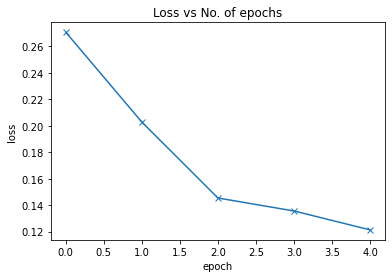

In [27]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No. of epochs')

* We concatenate the history with +=fit ~~.

In [28]:
aaa = [1,2,3]
aaa += [1]
aaa

[1, 2, 3, 1]

In [29]:
history += fit(2, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1057, val_acc: 0.9662
Epoch [1], val_loss: 0.1040, val_acc: 0.9683


* ```plt.subplot(number of rows, number of columns, pane index)```: This is how we set the pane index.
* Every time we draw a new plot, we determine the index by running this code. If we do not, they just plot two different lines in the same single plot.

Text(0.5, 1.0, 'Accuracy vs No. of epochs')

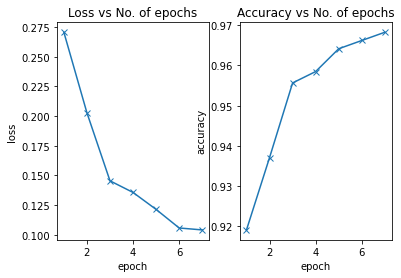

In [30]:
losses = [x['val_loss'] for x in history]
accuracies = [x['val_acc'] for x in history]

plt.subplot(1,2,1)
indices = list(range(len(history) + 1))
indices.remove(0)
plt.plot(indices, losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No. of epochs')

plt.subplot(1,2,2) # If we comment this line out, they graph two lines on the same plot.
plt.plot(indices, accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')

# 5. Test the Model

In [31]:
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

### predict individual objects

In [32]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


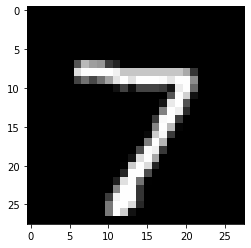

In [33]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

### assess overall accuracy 

In [34]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10608167946338654, 'val_acc': 0.9666992425918579}